In [1]:
import numpy as np
import qtree
import networkx as nx
import matplotlib.pyplot as plt
import copy

import utils

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


2020-03-01 22:21:52,726- INFO•	reading file ./qtree/test_circuits//inst/cz_v2/4x4/inst_4x4_30_0.txt
2020-03-01 22:21:52,737- INFO•	There are 16 qubits in circuit
2020-03-01 22:21:52,744- INFO•	Generated graph with 153 nodes and 299 edges
/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


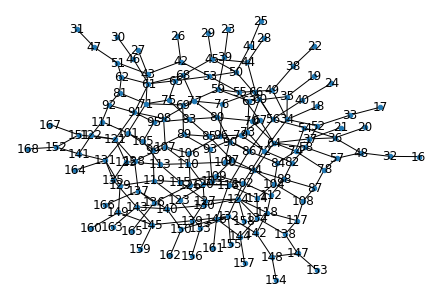

In [37]:
nqubits, circ = utils.test_circ('./qtree/test_circuits/', 4, depth=30)
graph = qtree.graph_model.circ2graph(nqubits, circ)
nx.draw_kamada_kawai(graph, node_size=20, with_labels=True)

In [38]:
peo, tw = qtree.graph_model.get_peo(graph)
print(tw, peo)

2020-03-01 22:21:53,629- INFO•	generating config file output/quickbb.93877840.cnf
2020-03-01 22:21:53,639- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.93877840.cnf 


14 [v_47, v_46, v_41, v_40, v_39, v_38, v_33, v_32, v_168, v_167, v_166, v_165, v_164, v_163, v_162, v_161, v_160, v_159, v_158, v_157, v_156, v_155, v_154, v_153, v_31, v_30, v_29, v_28, v_27, v_26, v_25, v_24, v_23, v_22, v_21, v_20, v_19, v_18, v_17, v_16, v_151, v_150, v_149, v_147, v_144, v_136, v_133, v_52, v_51, v_49, v_48, v_44, v_42, v_37, v_35, v_152, v_148, v_122, v_141, v_114, v_146, v_143, v_117, v_142, v_129, v_137, v_139, v_125, v_130, v_123, v_112, v_106, v_99, v_98, v_109, v_105, v_100, v_93, v_87, v_84, v_82, v_92, v_79, v_76, v_75, v_70, v_69, v_63, v_68, v_50, v_62, v_54, v_57, v_138, v_128, v_120, v_66, v_65, v_43, v_135, v_126, v_81, v_36, v_127, v_97, v_95, v_90, v_67, v_34, v_103, v_60, v_118, v_78, v_59, v_74, v_61, v_131, v_107, v_73, v_134, v_89, v_115, v_72, v_55, v_145, v_96, v_104, v_108, v_80, v_88, v_58, v_77, v_45, v_91, v_119, v_132, v_102, v_85, v_83, v_110, v_113, v_121, v_71, v_116, v_56, v_86, v_53, v_64, v_101, v_94, v_124, v_111, v_140]


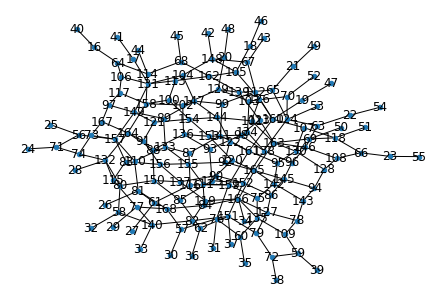

In [41]:
graph_opt, _ = utils.reorder_graph(graph, peo)
nx.draw_kamada_kawai(graph_opt, node_size=20, with_labels=True)

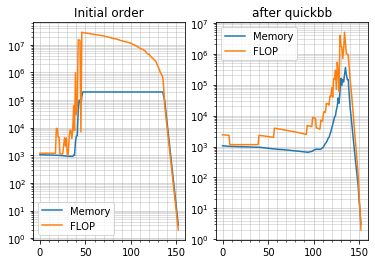

In [42]:
mems, flops = qtree.graph_model.cost_estimator(graph)
plt.subplot(121)
plt.title('Initial order')
utils.plot_cost(mems, flops)

plt.subplot(122)
plt.title('after quickbb')
mems, flops = qtree.graph_model.cost_estimator(graph_opt)
utils.plot_cost(mems, flops)

In [43]:
def get_locale_peo(old_graph, rule):
    # This is far below computationally effective
    graph = copy.deepcopy(old_graph)
    
    path= []
    vals = []
    while graph.number_of_nodes():
        #nodes = sorted(graph.nodes, key=int)
        nodes = list(graph.nodes)
        rule_ = lambda n: rule(graph, n)
        costs = list(map(rule_, nodes))
        _idx = np.argmin(costs)
        vals.append(costs[_idx])
        node = nodes[_idx]
        path.append(node)
        qtree.graph_model.eliminate_node(graph, node)
    return path, vals


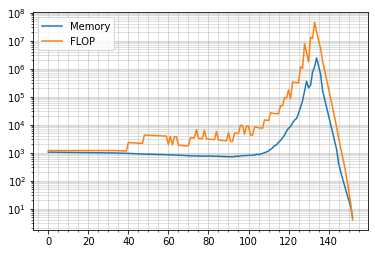

In [44]:
npeo, nghs = get_locale_peo(graph, n_neighbors)
graph_opt_loc, _ = utils.reorder_graph(graph, npeo)
mems, flops = qtree.graph_model.cost_estimator(graph_opt_loc)
utils.plot_cost(mems, flops)


nodes, ngh_loc = get_neighbours_path(graph_opt_loc)
nodes, ngh = get_neighbours_path(graph_opt)
plt.plot(nodes, ngh_loc, label=f'Node degree:  sum={sum(ngh_loc)}')
plt.plot(nodes, ngh, label=f'Quickbb: sum={sum(ngh)}')
plt.grid()
plt.legend()

nodes_s = sorted(graph_opt.nodes, key=int)
print(nodes)

print(nodes_s)


[x for x in locals().keys() if x[0] != '_']

In [57]:
nodes, ngh_loc = get_neighbours_path(graph_opt_loc)
nodes, ngh = get_neighbours_path(graph_opt)
plt.plot(nodes, ngh_loc, label=f'Node degree:  sum={sum(ngh_loc)}')
plt.plot(nodes, ngh, label=f'Quickbb: sum={sum(ngh)}')
plt.grid()
plt.legend()


NameError: name 'get_neighbours_path' is not defined

In [49]:
nodes_s = sorted(graph_opt.nodes, key=int)
print(nodes)

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]


In [151]:
print(nodes_s)

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]


['In', 'Out', 'get_ipython', 'exit', 'quit']

In [55]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [59]:
from IPython.core.magic import (Magics, magics_class, line_magic, cell_magic)

@magics_class
class Abracadabra(Magics):

    @line_magic
    def abra(self, line):
        return line

    @cell_magic
    def cadabra(self, line, cell):
        print(cell)
        return line, cell